**логистическая регрессия**  
нелинейный классификатор,  
метод градиентного спуска,  
регуляризация,  
моменты,  
с разделением данных,
оценка результата

Евгений Борисов borisov.e@solarl.ru

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import itertools    


from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import PolynomialFeatures

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

---

In [2]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

---

In [3]:
# # загружаем даные
# data = [
#     np.loadtxt('../data/200_2b/points_1.txt'),
#     np.loadtxt('../data/200_2b/points_2.txt')
# ]

In [4]:
# # загружаем даные
# data = [
#     np.loadtxt('data/1998_2/points_b.txt'),
#     np.loadtxt('data/1998_2/points_r.txt')
# ]
# n_pol=2

In [5]:
# загружаем даные
data = [
    np.loadtxt('../data/6402_2/points_1.txt'),
    np.loadtxt('../data/6402_2/points_2.txt')
]
n_pol=3

---

In [6]:
# собираем вместе
X = np.vstack(data)

n_cls = len(data) # количество классов


# метки классов
y = [ [i]*data[i].shape[0] for i in range(n_cls)]
y = [ item for sublist in y for item in sublist ]
y = np.asarray(y) # .reshape(n_ex,1)

X.shape, y.shape

((6402, 2), (6402,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=get_seed() )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((640, 2), (640,), (5762, 2), (5762,))

In [8]:
%xdel data
%xdel X

In [9]:
# нормируем данные
scaler = MinMaxScaler([-1.0,1.0])
scaler.fit(X_train)
X_train = scaler.transform(X_train)


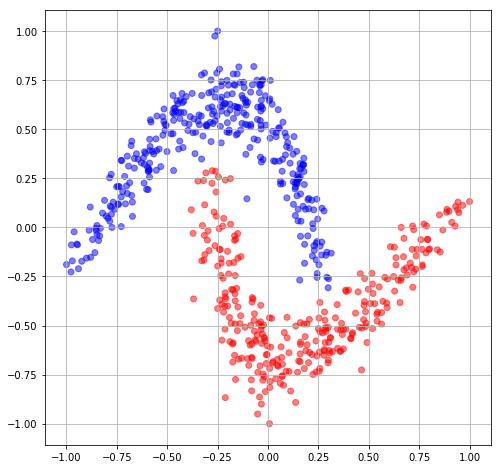

In [10]:
c = [ ['b','r'][int(j>0.5)] for j in y_train  ]
plt.figure(figsize=(8,8))
plt.scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
plt.grid()
plt.show()


---

In [11]:
# собираем полином
poly = PolynomialFeatures(n_pol)
poly.fit(X_train)
Xp = poly.transform(X_train)
n_par = Xp.shape[1] # количество параметров

Xp.shape

(640, 10)

In [12]:
def act(z): return 1.0/(1.0 + np.exp(-z))

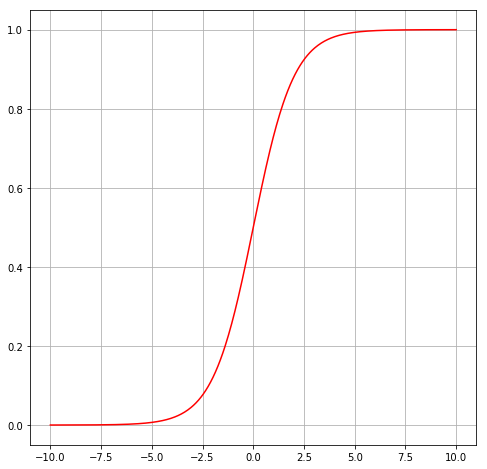

In [13]:
plt.figure(figsize=(8,8))
z=np.linspace(-10,10,500)
plt.plot( z,act(z),'-r' )
plt.grid()
plt.show()

In [14]:
# инициализация параметров
np.random.seed(get_seed())
T = np.random.normal(loc=0.0, scale=0.1, size=n_par)
T

array([-0.00919499, -0.14633507,  0.10817917, -0.02393252, -0.04911291,
       -0.1002272 ,  0.09188215, -0.11036321,  0.06264935, -0.05615138])

In [15]:
# ф-ция потери - кросс-энтропия

def loss(o,y):
    o_restr = np.minimum(0.99999,np.maximum(1e-9,o))
    return -( y*np.log(o_restr) + (1-y)*np.log(1.0-o_restr) ).sum() / y.shape[0]    

# def CrossEntropy(yHat, y):
#     if y == 1:
#       return -log(yHat)
#     else:
#       return -log(1 - yHat)

In [16]:
# метод градиентного спуска

a=0.1 # скорость обучения

MAX_ITER = 1500 # максимальное число циклов обучения

MIN_ERROR = 0.01 # порог минимальной ошибки

er_hist = [] # история ошибки

n_ex = X_train.shape[0] # количество учебных примеров

r = 0.05 # коэфициент регуляризации
mu = 0.05 # коэфициент момента

r = 0.05 # коэфициент регуляризации
mu = 0.05 # коэфициент момента

dT=0.0

In [17]:
for i in range(MAX_ITER):
    
    O = act(Xp.dot(T)) # выход
    E = O - y_train # ошибка
    
    er_hist.append( loss(O,y_train) ) # значение ф-ции потери     
    
    if er_hist[-1] < MIN_ERROR: # проверяем достижение порога
        print(i,'min error ',er_hist[-1])
        break
    
    dE = (Xp*E.reshape(n_ex,1)).sum(axis=0).reshape(T.shape)
    dE /= np.linalg.norm(dE) # нормируем градиент
    
    dT = a*(dE+r*T) + mu*dT
    
    T = T - dT 
   

In [18]:
print(T)
print(len(er_hist),er_hist[-1],min(er_hist))

[-0.28592499 -6.11131122 -7.8084746   0.96688287 -0.28007874  0.3890273
 16.11867684 -4.06375461  2.07868175 -4.40897177]
1500 0.08465491616934596 0.08465491616934596


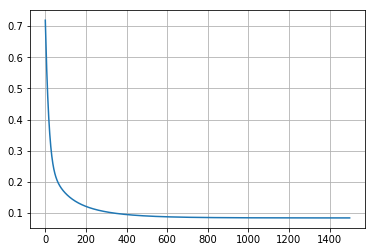

In [19]:
plt.plot(range(len(er_hist)),er_hist)
plt.grid()
plt.show()

---

In [20]:
X_test = scaler.transform(X_test)
Xp =  poly.transform( X_test )
Xp.shape

(5762, 10)

In [21]:
score_bound=0.5
o = act(Xp.dot(T))

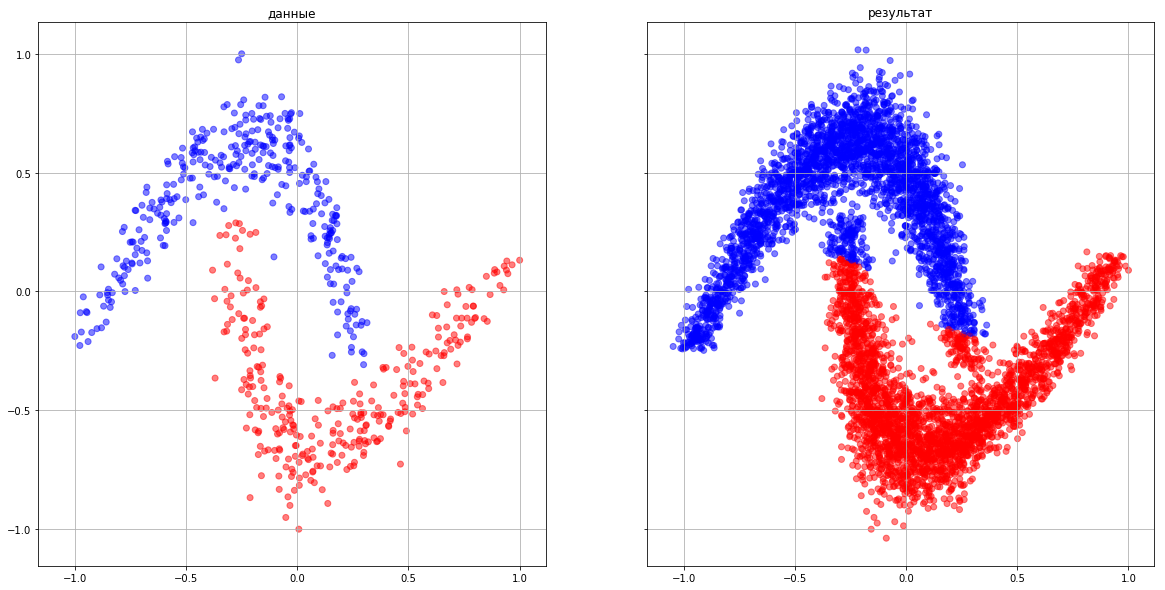

In [22]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(20,10),)
    
c = [ ['b','r'][int(j>0.5)] for j in y_train  ]
axarr[0].set_title('данные')
axarr[0].set
axarr[0].scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r'][int(j>score_bound)] for j in o  ]
axarr[1].set_title('результат')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()


---

In [23]:
r = (o>0.5).astype(int)

In [24]:
print( classification_report(y_test,r) )

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      2830
          1       0.97      0.96      0.96      2932

avg / total       0.96      0.96      0.96      5762



---

In [25]:
cm = confusion_matrix(y_test,r)
print(cm)

[[2729  101]
 [ 128 2804]]


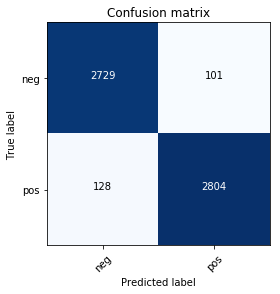

In [26]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')
# plt.colorbar()

classes=['neg','pos']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

---

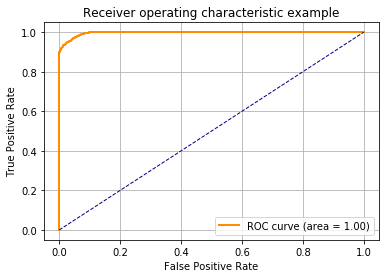

In [27]:
fpr, tpr, thresholds = roc_curve( y_test, o )
roc_auc = auc(fpr,tpr)

plt.figure()
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

---

In [28]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки

xx.shape, yy.shape

((500, 500), (500, 500))

In [29]:
xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
xy.shape

(250000, 2)

In [30]:
# xy = np.hstack( [ np.ones([n*n,1]) , xy ] )
xy = poly.transform(xy)
p = act(xy.dot(T)).reshape(n,n) # вычисляем скор для каждого узла сетки

In [31]:
c = [ ['b','r'][ int(j>0.5) ] for j in y_test  ]

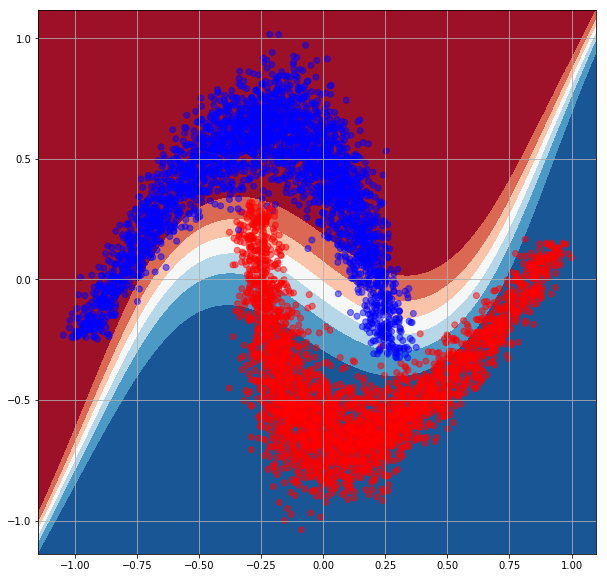

In [32]:
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, p, cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=c, alpha=.5 )
plt.grid()
plt.show()